In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
df_subscriptions = pd.read_csv("user_subscriptions.csv")

In [3]:
df_subscriptions['End Date'] = df_subscriptions['End Date'].fillna('Jan-19')

In [4]:
df_subscriptions["Join Date"] = df_subscriptions["Join Date"].apply(lambda x: datetime.strptime(str(x),"%b-%y") if pd.notnull(x) else '')
df_subscriptions["End Date"] = df_subscriptions["End Date"].apply(lambda x: datetime.strptime(str(x),"%b-%y") if pd.notnull(x) else '')

In [5]:
df_subscriptions["Cohort"] = df_subscriptions["Join Date"].apply(lambda x: str(x.year) + 'Q' + str(x.quarter))

In [6]:
df_subscriptions['Months Subscribed'] = (df_subscriptions['End Date'] - df_subscriptions['Join Date']).astype('timedelta64[M]')
df_subscriptions['Months Subscribed'] = df_subscriptions['Months Subscribed'].astype('int') + 1

In [7]:
df_subscriptions = df_subscriptions.set_index("Join Date").groupby(["CustomerID", pd.Grouper(freq='Q')]).agg({
        "End Date": "first",
        "Cohort": "first",
        "Months Subscribed": "first"
    })

In [8]:
df_subscriptions = df_subscriptions.reset_index()

In [9]:
grouped = df_subscriptions.groupby(['Cohort', 'Months Subscribed'])

# count the unique customers per Cohort & Months Subscribed
cohorts = grouped.agg({'CustomerID': pd.Series.nunique})
cohorts.rename(columns={'CustomerID': 'TotalCustomers'}, inplace=True)

In [10]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['Cohort', 'Months Subscribed'], inplace=True)

# Calculate the total number of customers per cohort
cohort_group_size = cohorts['TotalCustomers'].groupby(level=0).sum()

In [11]:
user_retention = cohorts['TotalCustomers'].unstack(0).divide(cohort_group_size, axis=1)

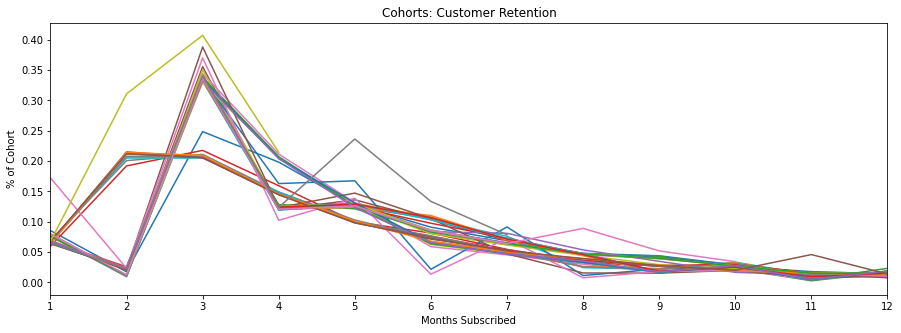

In [12]:
user_retention.plot(figsize=(15,5), legend=None)
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort');

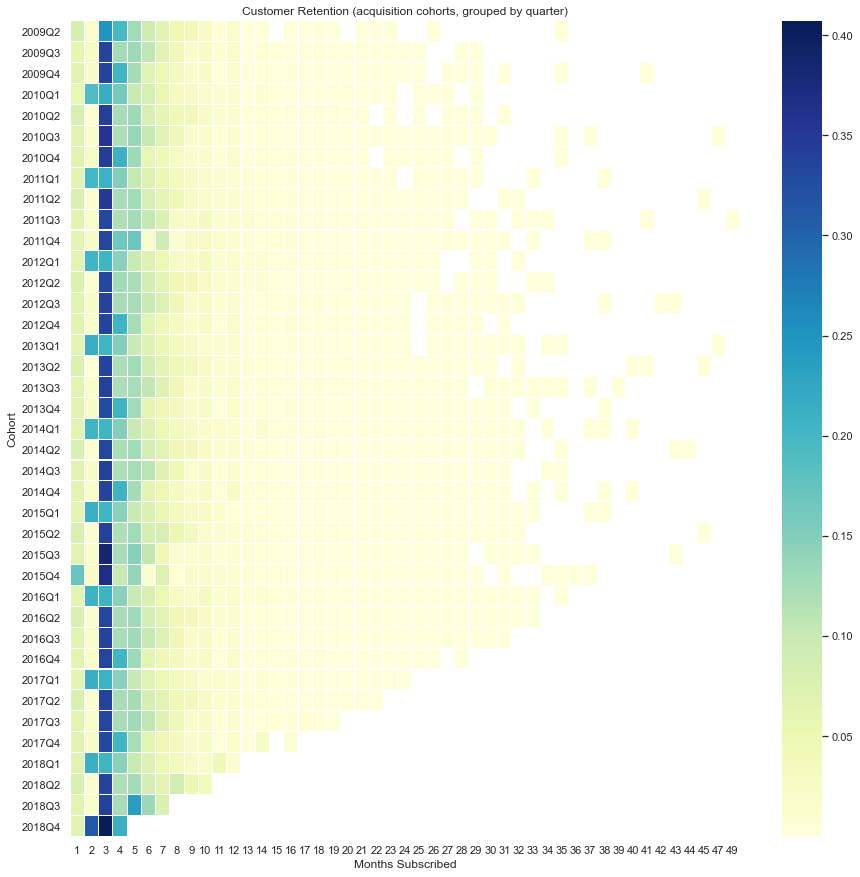

In [13]:
sns.set(style='white')
plt.figure(figsize=(15, 15))
plt.title('Customer Retention (acquisition cohorts, grouped by quarter)')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=False, fmt='.0%', cmap="YlGnBu", linewidths=.1);